In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
using Random

In [2]:
@model function rotate_ssm(n, θ, x0, Q::ConstVariable, P::ConstVariable)
    
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior ~ MvNormalMeanCovariance(mean(x0), cov(x0))
    
    x_prev = x_prior
    
    A = constvar([ cos(θ) -sin(θ); sin(θ) cos(θ) ])
    
    for i in 1:n
        x[i] ~ MvNormalMeanCovariance(A * x_prev, Q) where { q = q(out, mean)q(cov) }
        y[i] ~ MvNormalMeanCovariance(x[i], P) where { q = q(out)q(mean)q(cov) }
        
        x_prev = x[i]
    end
    
    return x, y
end

rotate_ssm (generic function with 1 method)

In [15]:
Random.seed!(1234)

θ = π / 8
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
Q = Matrix(Diagonal(1.0 * ones(2)))
P = Matrix(Diagonal(1.0 * ones(2)))

n = 300

x_prev = [ 10.0, -10.0 ]

x = Vector{Vector{Float64}}(undef, n)
y = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    x[i] = rand(MvNormal(A * x_prev, Q))
    y[i] = rand(MvNormal(x[i], Q))
    
    x_prev = x[i]
end

In [16]:
using Plots

In [17]:
slicedim(dim) = (a) -> map(e -> e[dim], a)

slicedim (generic function with 1 method)

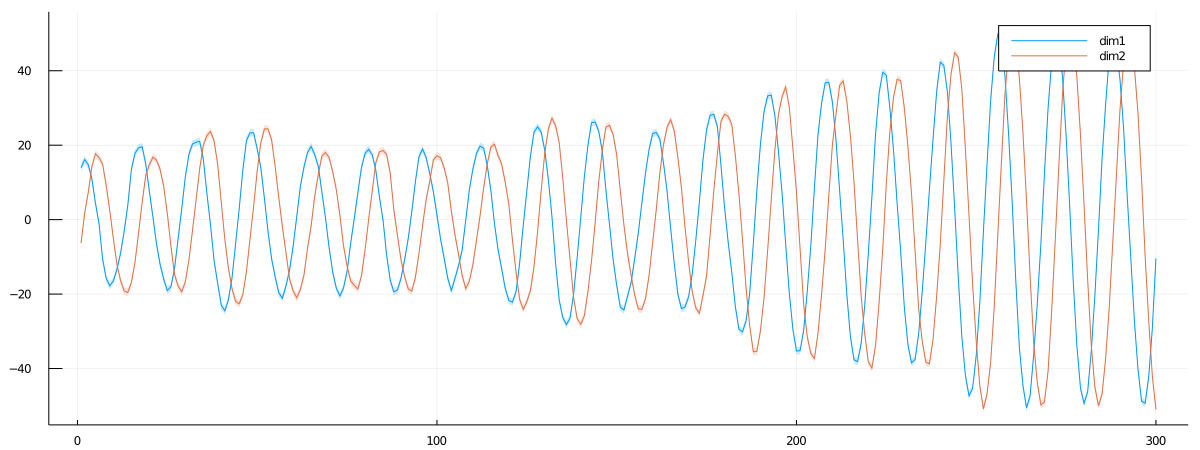

In [18]:
px = plot()

px = plot!(px, x |> slicedim(1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "dim1")
px = plot!(px, x |> slicedim(2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "dim2")

plot(px, size = (1200, 450))

In [19]:
function inference(observations, θ, x0)

    model, (x, y) = rotate_ssm(n, θ, x0, Q, P);

    ms_buffer = Vector{Marginal}(undef, n)
    fe_buffer = nothing
    
    marginals = getmarginals(x)

    fe_subscription = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)
    ms_subscription = subscribe!(marginals, (ms) -> copyto!(ms_buffer, ms))
    
    update!(y, observations)

    unsubscribe!(ms_subscription)
    unsubscribe!(fe_subscription)
    
    return ms_buffer, fe_buffer
end

inference (generic function with 1 method)

In [20]:
function f(θ)
    x0 = MvNormalMeanCovariance([ θ[2], θ[3] ], Matrix(Diagonal(0.01 * ones(2))))
    xmarginals, fe = inference(y, θ[1], x0); 
    return fe
end

f (generic function with 1 method)

In [21]:
using Optim

In [22]:
res = optimize(f, zeros(3), LBFGS(), Optim.Options(f_tol = 1e-14, g_tol = 1e-12, show_trace = true))

Iter     Function value   Gradient norm 
     0     2.192003e+04     9.032537e+04
 * time: 0.019726991653442383
     1     4.596100e+03     4.422999e+04
 * time: 11.412678003311157
     2     1.237347e+03     3.498283e+02
 * time: 12.259505987167358
     3     1.237151e+03     6.975548e+00
 * time: 13.099493026733398
     4     1.161373e+03     2.314257e+01
 * time: 17.72005319595337
     5     1.161372e+03     1.119285e-03
 * time: 18.5425021648407
     6     1.161372e+03     1.876302e-03
 * time: 22.34386706352234
     7     1.161372e+03     2.065172e-06
 * time: 23.622472047805786
     8     1.161372e+03     4.693572e-07
 * time: 24.478836059570312
     9     1.161372e+03     1.689686e-07
 * time: 25.3404381275177


 * Status: success

 * Candidate solution
    Final objective value:     1.161372e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.53e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.23e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.82e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.87e-16 ≤ 1.0e-14
    |g(x)|                 = 1.69e-07 ≰ 1.0e-12

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    9
    f(x) calls:    57
    ∇f(x) calls:   57


In [23]:
println("Real value vs Optimized")
println("Real:      ", θ)
println("Optimized: ", res.minimizer)

Real value vs Optimized
Real:      0.39269908169872414
Optimized: [0.3929332481402352, 10.85162622949665, -11.357240225357778]


In [24]:
@show sin(θ), sin(res.minimizer[1])
@show cos(θ), cos(res.minimizer[1])

(sin(θ), sin(res.minimizer[1])) = (0.3826834323650898, 0.38289976345360893)
(cos(θ), cos(res.minimizer[1])) = (0.9238795325112867, 0.9237898955645544)


(0.9238795325112867, 0.9237898955645544)

In [25]:
xmarginals, fe = inference(y, res.minimizer[1], MvNormalMeanCovariance([ res.minimizer[2], res.minimizer[3] ], Matrix(Diagonal(100.0 * ones(2)))));

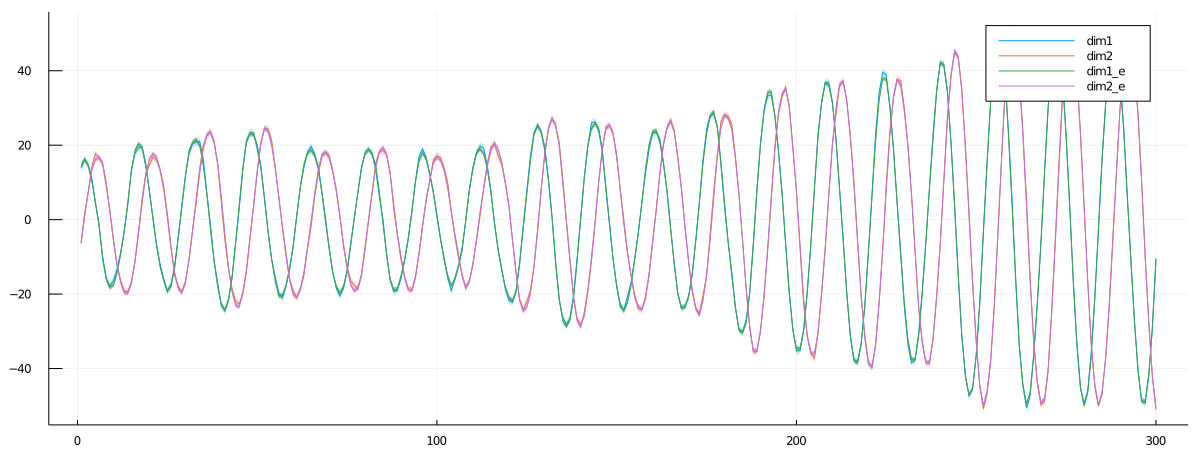

In [26]:
px = plot()

px = plot!(px, x |> slicedim(1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "dim1")
px = plot!(px, x |> slicedim(2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "dim2")
px = plot!(px, mean.(xmarginals) |> slicedim(1), ribbon = var.(xmarginals) |> slicedim(1) .|> sqrt, fillalpha = 0.5, label = "dim1_e")
px = plot!(px, mean.(xmarginals) |> slicedim(2), ribbon = var.(xmarginals) |> slicedim(2) .|> sqrt, fillalpha = 0.5, label = "dim2_e")

plot(px, size = (1200, 450))